In [1]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
import pandas as pd
import os
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import shapely
from scipy.io import readsav
import scipy.interpolate
from astropy.visualization import (ImageNormalize, SqrtStretch, AsinhStretch)
from eis_straylight import calc_short_range_stray_light, calc_long_range_stray_light_aia_eis, coalign_eis_aia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator

In [2]:
aia_131_map = sunpy.map.Map('../../src/AIA/20221025/131/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.131.image.fits')
aia_171_map = sunpy.map.Map('../../src/AIA/20221025/171/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.171.image.fits')
aia_193_map = sunpy.map.Map('../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits')
aia_211_map = sunpy.map.Map('../../src/AIA/20221025/211/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.211.image.fits')
aia_335_map = sunpy.map.Map('../../src/AIA/20221025/335/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.335.image.fits')
aia_94_map = sunpy.map.Map('../../src/AIA/20221025/94/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.94.image.fits')

In [3]:
eis_file_prefix = '../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.'

In [6]:
eis_FeXII_195_fitres = eispac.read_fit(eis_file_prefix + 'fe_12_195_119.1c-0.fit.h5')
eis_FeXII_195_intmap = eis_FeXII_195_fitres.get_map(component=0, measurement='intensity')
eis_FeXII_195_velmap = eis_FeXII_195_fitres.get_map(component=0, measurement='velocity')

Txshift_aia_eis_rough, Tyshift_aia_eis_rough = coalign_eis_aia(eis_FeXII_195_intmap, aia_193_map)
eis_FeXII_195_intmap = eis_FeXII_195_intmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)
eis_FeXII_195_velmap = eis_FeXII_195_velmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [51]:
eis_FeXIV_264_fitres = eispac.read_fit(eis_file_prefix + 'fe_14_264_787.1c-0.fit.h5')
eis_FeXIV_264_intmap = eis_FeXIV_264_fitres.get_map(component=0, measurement='intensity')
eis_FeXIV_264_intmap.plot()

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_14_264_787.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


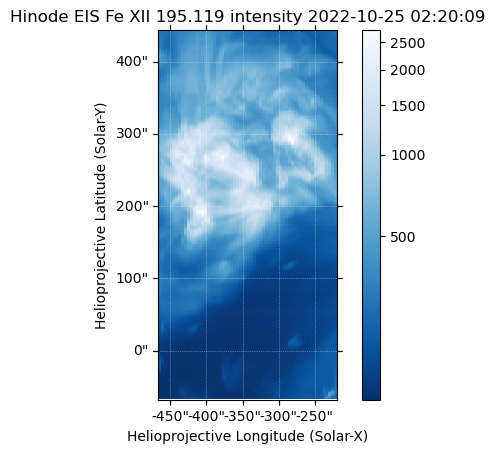

In [7]:
eis_FeXII_195_intmap.plot()
plt.colorbar()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(150.0, 350.0)

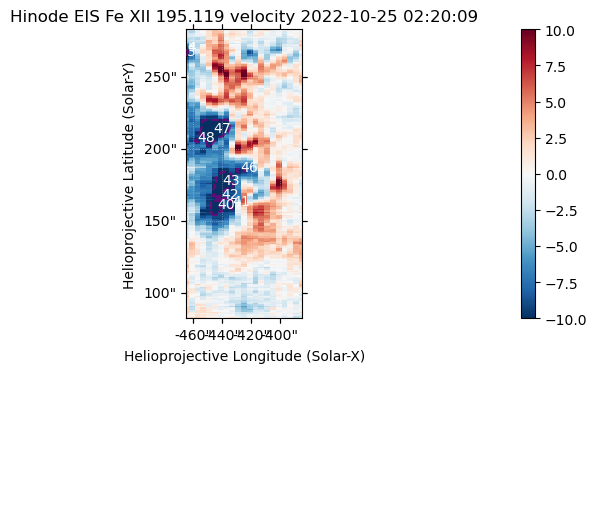

In [8]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)

cs = eis_FeXII_195_velmap.draw_contours(levels=[-10,]*eis_FeXII_195_velmap.unit,colors=["purple"],axes=ax,alpha=0.8)
plt.colorbar()

for ii, seg in enumerate(cs.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

ax.set_xlim(0,20)
ax.set_ylim(150,350)

In [9]:
cs_selected_index = [47,43,40,46]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index:
    ax.plot(*cs.allsegs[0][ii].T, color='red', lw=2)

In [10]:
cs_skycoords = [eis_FeXII_195_velmap.pixel_to_world(cs.allsegs[0][cs_index][:-1,0]*u.pix,cs.allsegs[0][cs_index][:-1,1]*u.pix) \
                for cs_index in cs_selected_index]
cs_regions = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords]

In [12]:
coronal_hole_ref_region_center=SkyCoord(-330*u.arcsec, 30*u.arcsec, frame=eis_FeXII_195_intmap.coordinate_frame)
eis_FeXII_195_intmap_coronal_hole_pixel_region = EllipsePixelRegion(center=PixCoord.from_sky(coronal_hole_ref_region_center, eis_FeXII_195_intmap.wcs),
                                            width=(60*u.arcsec/eis_FeXII_195_intmap.scale.axis1).to_value(u.pix), 
                                            height=(60*u.arcsec/eis_FeXII_195_intmap.scale.axis2).to_value(u.pix))

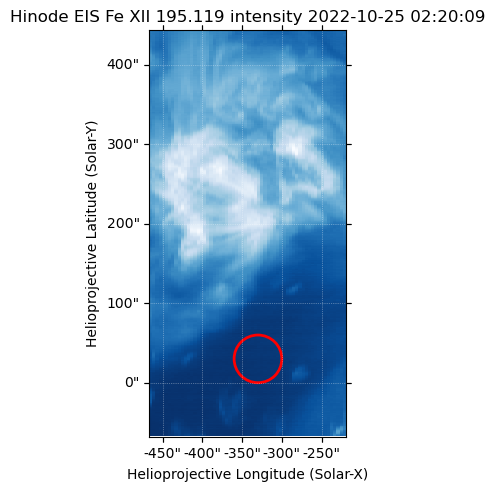

In [13]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_intmap)
eis_FeXII_195_intmap.plot(axes=ax)

eis_FeXII_195_intmap_coronal_hole_pixel_region.plot(ax=ax, edgecolor='red', lw=2)

In [14]:
coronal_hole_ref_region_params = {'center':coronal_hole_ref_region_center, 'width':60*u.arcsec, 'height':60*u.arcsec}

In [15]:
def get_sky_region_centroid(sky_region, wcs):
    pixel_region = sky_region.to_pixel(wcs)
    pixel_region_shapely = shapely.geometry.Polygon(np.vstack(pixel_region.vertices.xy).T)
    pixel_region_shapely_centroid = pixel_region_shapely.centroid
    sky_coord_centroid = wcs.pixel_to_world(pixel_region_shapely_centroid.x, pixel_region_shapely_centroid.y)

    return sky_coord_centroid

In [16]:
FeXII_195_sr_stray_light, FeXII_195_sr_stray_light_region = calc_short_range_stray_light(eis_FeXII_195_intmap,
                                                                                        get_sky_region_centroid(cs_regions[0], eis_FeXII_195_intmap.wcs),
                                                                                        return_region=True)

Short range stray light: 137.75


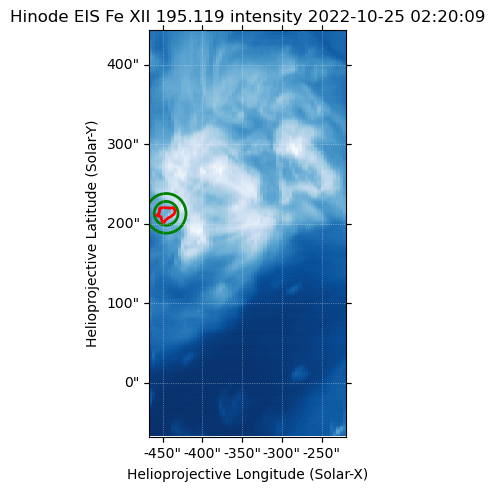

In [17]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_intmap)
eis_FeXII_195_intmap.plot(axes=ax)

FeXII_195_sr_stray_light_region.plot(ax=ax, edgecolor='green', lw=2)
cs_regions[0].to_pixel(eis_FeXII_195_intmap.wcs).plot(ax=ax, edgecolor='red', lw=2)

print(f'Short range stray light: {FeXII_195_sr_stray_light:.2f}')

In [18]:
FeXII_lr_stray_light, FeXII_lr_stray_light_coalign_region, _ = calc_long_range_stray_light_aia_eis(eis_FeXII_195_intmap, aia_193_map,
                                                           SkyCoord(-440*u.arcsec, 100*u.arcsec, frame=eis_FeXII_195_intmap.coordinate_frame),
                                                           region_radius = 50*u.arcsec, return_region=True)

Long range stray light: 14.27


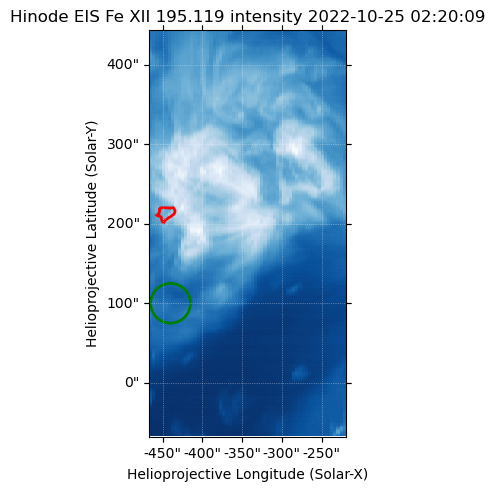

In [19]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_intmap)
eis_FeXII_195_intmap.plot(axes=ax)

FeXII_lr_stray_light_coalign_region.plot(ax=ax, edgecolor='green', lw=2)
cs_regions[0].to_pixel(eis_FeXII_195_intmap.wcs).plot(ax=ax, edgecolor='red', lw=2)

print(f'Long range stray light: {FeXII_lr_stray_light:.2f}')

In [20]:
def get_intensity_from_cs_regions(intensity_map, cs_regions):
    intensity = []
    masks = [np.where(cs_region.contains(sunpy.map.all_coordinates_from_map(intensity_map), 
                                                intensity_map.wcs)) for cs_region in cs_regions]
    intensity = [intensity_map.data[mask_] for mask_ in masks]
    return intensity

In [21]:
def mean_intensity_in_region(regions_intensity, min=None, max=None):
    if max is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity > max)
            region_intensity[mask] = np.nan
    if min is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity < min)
            region_intensity[mask] = np.nan
    return np.array([np.nanmean(region_intensity) for region_intensity in regions_intensity])

In [22]:
eis_radcal_file = readsav('../../sav/eis_radcal_20221025.sav',verbose=True)

--------------------------------------------------
Date: Thu Jun 27 11:54:26 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 11 records of which:
 - 8 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - sw_wvl [<class 'numpy.ndarray'>]
 - lw_wvl [<class 'numpy.ndarray'>]
 - gdz_sw [<class 'numpy.ndarray'>]
 - gdz_lw [<class 'numpy.ndarray'>]
 - hpw_sw [<class 'numpy.ndarray'>]
 - hpw_lw [<class 'numpy.ndarray'>]
 - new_sw [<class 'numpy.ndarray'>]
 - new_lw [<class 'numpy.ndarray'>]
--------------------------------------------------


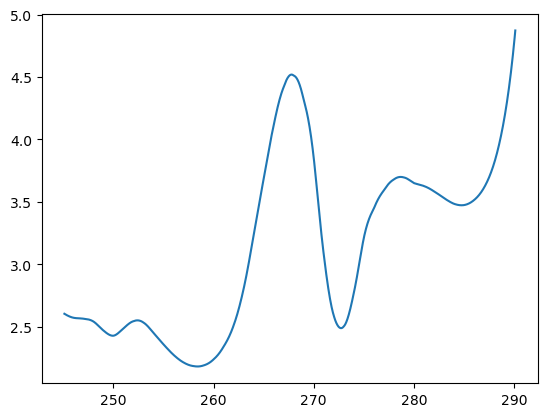

In [139]:
plt.plot(eis_radcal_file['lw_wvl'], eis_radcal_file['new_lw'])

In [23]:
def get_eis_radcal(wvl,radcal_file=eis_radcal_file,method='hpw'):
    if isinstance(wvl, u.Quantity):
        wvl = wvl.to_value(u.angstrom)
        
    if method == 'hpw':
        lw_radcal = radcal_file['hpw_lw']
        sw_radcal = radcal_file['hpw_sw']
    elif method == 'lpw':
        lw_radcal = radcal_file['lpw_lw']
        sw_radcal = radcal_file['lpw_sw']
    elif method == 'new':
        lw_radcal = radcal_file['new_lw']
        sw_radcal = radcal_file['new_sw']
    
    if 165 < wvl < 212:
        radcal = sw_radcal
        wvl_grid = radcal_file['sw_wvl']
    elif 245 < wvl < 292:
        radcal = lw_radcal
        wvl_grid = radcal_file['lw_wvl']
    else:
        raise ValueError('Wavelength out of range')
    
    radcal_interp_func = scipy.interpolate.interp1d(wvl_grid, radcal, kind='cubic', fill_value='extrapolate')
    return radcal_interp_func(wvl)

In [24]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [59]:
def read_eis_fit_and_return_upflow_int(eis_file_prefix, eis_line_name,cs_regions,
                                       component=0, radcal_file=eis_radcal_file, method='hpw',
                                       int_hist=0, min=None, max=None, reference_region_params=None,
                                       short_range_stray_light=False, long_range_stray_light=False,
                                       long_range_stray_light_aia_ref=None, 
                                       long_range_stray_light_ref_center=None,
                                       long_range_stray_light_ref_radius=None,
                                       eis_aia_shift = (Txshift_aia_eis_rough, Tyshift_aia_eis_rough),
                                       eis_chi2_mask_threshold=50):
    
    eis_fitres = eispac.read_fit(eis_file_prefix + eis_line_name + '.fit.h5')
    eis_intmap = eis_fitres.get_map(component=component, measurement='intensity')

    if eis_chi2_mask_threshold is not None and eis_chi2_mask_threshold > 0:
        chi2_mask = np.where(eis_fitres.fit['chi2'] > eis_chi2_mask_threshold)
        eis_intdata = eis_intmap.data.copy()
        eis_intdata[chi2_mask] = np.nan
        eis_intmap = sunpy.map.Map(eis_intdata, eis_intmap.meta)
        
    if eis_aia_shift is not None:
        eis_intmap = eis_intmap.shift_reference_coord(*eis_aia_shift)
    eis_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_intmap.data, 0.5),
                                                      vmax=np.nanpercentile(eis_intmap.data, 99.5),
                                                      stretch=AsinhStretch(0.1))
    eis_intmap.plot_settings['cmap'] = 'plasma'

    eis_regions_int = get_intensity_from_cs_regions(eis_intmap, cs_regions)
    eis_regions_int_mean = mean_intensity_in_region(eis_regions_int, min=min, max=max)
    eis_radcal_factor = get_eis_radcal(eis_intmap.wavelength, radcal_file=radcal_file, method=method)
    eis_regions_int_mean_radcal = eis_regions_int_mean*eis_radcal_factor
    
    fig = plt.figure(figsize=(7, 5),layout='constrained')
    ax = fig.add_subplot(111, projection=eis_intmap)
    eis_intmap.plot(axes=ax)
    
    for ii, region in enumerate(cs_regions):
        ax.plot_coord(region.vertices, color='red', lw=2, label='Upflow Region' if ii == 0 else '')
    
    if reference_region_params is not None:
        referene_circle_pixel_region = EllipsePixelRegion(center=PixCoord.from_sky(reference_region_params['center'], eis_intmap.wcs),
                                            width=(reference_region_params['width']/eis_intmap.scale.axis1).to_value(u.pix), 
                                            height=(reference_region_params['height']/eis_intmap.scale.axis2).to_value(u.pix))
        referene_circle_pixel_region.plot(ax=ax, edgecolor='blue', lw=2, label='CH Ref. Region')

    if short_range_stray_light or long_range_stray_light:
        stray_light_int = np.zeros((len(cs_regions),2))
        sr_stray_light_regions = []
        if short_range_stray_light is True:
            for ii, region in enumerate(cs_regions):
                sr_stray_light, sr_stray_light_region = calc_short_range_stray_light(eis_intmap,
                                                                                    get_sky_region_centroid(region, eis_intmap.wcs),
                                                                                    return_region=True)
                stray_light_int[ii,0] = sr_stray_light
                sr_stray_light_regions.append(sr_stray_light_region)

        if long_range_stray_light is True:
            lr_stray_light, lr_stray_light_coalign_region, lr_stray_light_aia_region = \
                            calc_long_range_stray_light_aia_eis(eis_intmap, long_range_stray_light_aia_ref,
                            SkyCoord(*long_range_stray_light_ref_center, frame=eis_intmap.coordinate_frame),
                            region_radius = long_range_stray_light_ref_radius,
                            return_region=True)
            
            lr_stray_light_coalign_region.plot(ax=ax, edgecolor='yellow', lw=2, label='LRSL Ref. Region')
            stray_light_int[:,1] = lr_stray_light

            aia_map_crop = long_range_stray_light_aia_ref.submap(eis_intmap.bottom_left_coord, top_right=eis_intmap.top_right_coord)
            fig_aia = plt.figure(figsize=(7, 5),layout='constrained')
            ax_aia = fig_aia.add_subplot(111, projection=aia_map_crop)
            aia_map_crop.plot(axes=ax_aia)
            lr_stray_light_aia_region.to_sky(long_range_stray_light_aia_ref.wcs).to_pixel(aia_map_crop.wcs).plot(ax=ax_aia, edgecolor='yellow', lw=2, label='LRSL AIA Ref. Region')
            
    if int_hist is not False:
        if isinstance(int_hist, int) and (0 <= int_hist < len(cs_regions)):
            fig_hist, ax_hist = plt.subplots(layout='constrained')
            ax_hist.hist(eis_regions_int[int_hist], bins=10, histtype='step', color='red', lw=2, 
                    range=(np.nanmin(eis_regions_int[int_hist]),np.nanmax(eis_regions_int[int_hist])),
                    label='Region ' + str(int_hist), weights=np.ones_like(eis_regions_int[int_hist])/len(eis_regions_int[int_hist]))
            
            if min is not None:
                ax_hist.axvline(min, color='red', lw=2, ls='--')
            if max is not None:
                ax_hist.axvline(max, color='red', lw=2, ls='--')
        
        if reference_region_params is not None:
            reference_region_mask = np.where(referene_circle_pixel_region.contains(PixCoord.from_sky(sunpy.map.all_coordinates_from_map(eis_intmap),
                                                                                                     eis_intmap.wcs)))
            ax_hist.hist(eis_intmap.data[reference_region_mask], bins=10, histtype='step', color='blue', lw=2, 
                    range=(np.nanmin(eis_intmap.data[reference_region_mask]),np.nanmax(eis_intmap.data[reference_region_mask])),
                    label='Reference Region', weights=np.ones_like(eis_intmap.data[reference_region_mask])/len(eis_intmap.data[reference_region_mask]))
            
        if short_range_stray_light is True:
            ax_hist.axvline(stray_light_int[int_hist,0], color='green', lw=2, ls='--', label='SR Stray Light')
            sr_stray_light_regions[int_hist].plot(ax=ax, edgecolor='green', lw=2, label='SRSL Region')

        if long_range_stray_light is True:
            ax_hist.axvline(stray_light_int[int_hist,1], color='yellow', lw=2, ls='--', label='LR Stray Light')

        if short_range_stray_light is True and long_range_stray_light is True:
            ax_hist.axvline(np.sum(stray_light_int[int_hist,:]), color='purple', lw=2, ls='--', label='Total Stray Light')
        
        ax_hist.legend(loc='upper right')
        ax_hist.set_xlabel(r'Pre-flight Intensity [erg cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')

    
        ax_leg = ax.legend(bbox_to_anchor=(1.4, 0.7, 0.5, 0.3))
        leg_box = ax_leg.get_window_extent(renderer=fig.canvas.get_renderer())
        leg_box_ax_coords = leg_box.transformed(ax.transAxes.inverted())

        plot_colorbar(ax.images[0],ax,width='5%',bbox_to_anchor=(1.07, 0., 1, leg_box_ax_coords.y0 - 0.05),fontsize=12)

    if short_range_stray_light is True or long_range_stray_light is True:
        return eis_regions_int_mean_radcal, stray_light_int*eis_radcal_factor
    else:
        return eis_regions_int_mean_radcal

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_08_185_213.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


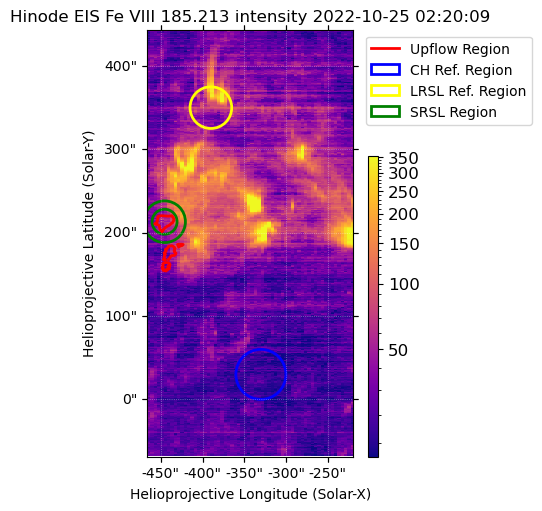

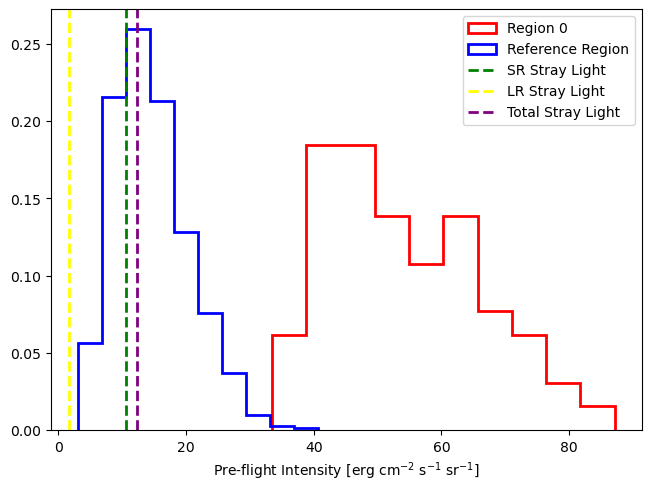

In [75]:
eis_FeVIII_185_upflow_regions_int_mean_radcal, \
eis_FeVIII_185_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_08_185_213.1c-0', cs_regions,
                                                                                   reference_region_params=coronal_hole_ref_region_params,
                                                                                   short_range_stray_light=True, 
                                                                                   long_range_stray_light=True,
                                                                                   long_range_stray_light_aia_ref=aia_131_map,
                                                                                   long_range_stray_light_ref_center=[-390,350]*u.arcsec,
                                                                                   long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_08_186_601.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


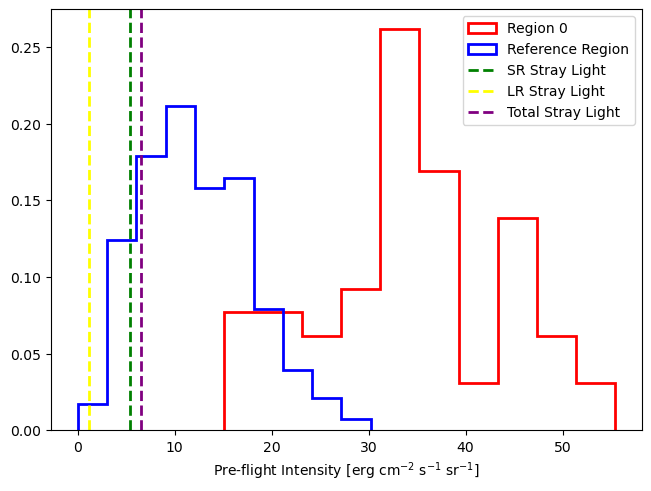

In [76]:
eis_FeVIII_186_upflow_regions_int_mean_radcal, \
eis_FeVIII_186_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_08_186_601.1c-0', cs_regions,
                                                                                   reference_region_params=coronal_hole_ref_region_params,
                                                                                   short_range_stray_light=True,
                                                                                   long_range_stray_light=True,
                                                                                   long_range_stray_light_aia_ref=aia_131_map,
                                                                                   long_range_stray_light_ref_center=[-390,350]*u.arcsec,
                                                                                   long_range_stray_light_ref_radius=50*u.arcsec)


Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_09_188_497.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


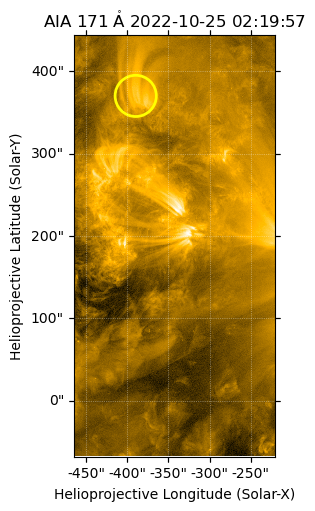

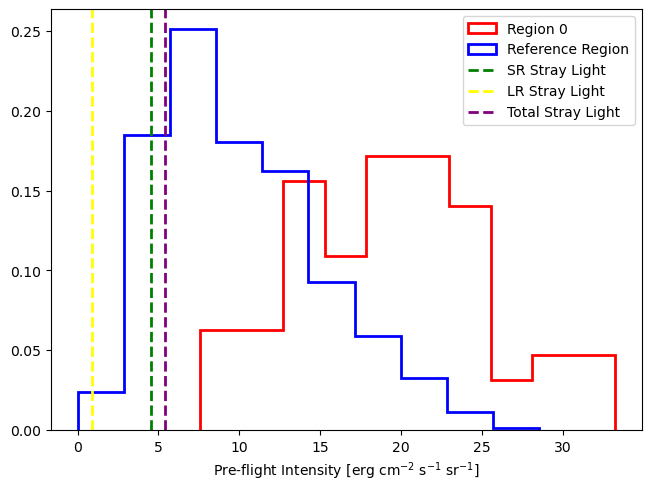

In [77]:
eis_FeIX_188_upflow_regions_int_mean_radcal, \
eis_FeIX_188_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_09_188_497.1c-0', cs_regions,
                                                                                 reference_region_params=coronal_hole_ref_region_params,
                                                                                 short_range_stray_light=True,
                                                                                 long_range_stray_light=True,
                                                                                 long_range_stray_light_aia_ref=aia_171_map,
                                                                                 long_range_stray_light_ref_center=[-390,370]*u.arcsec,
                                                                                 long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_09_197_862.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


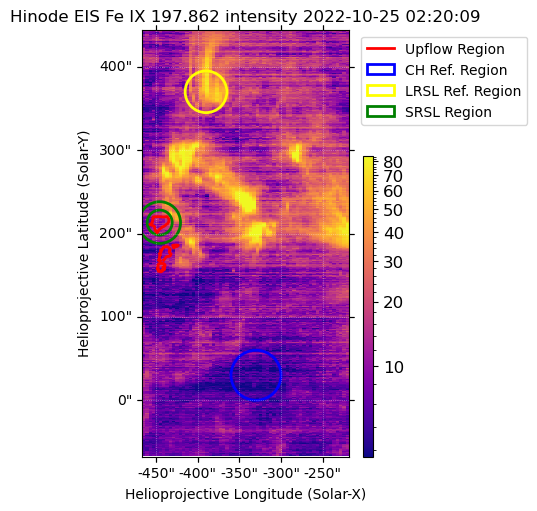

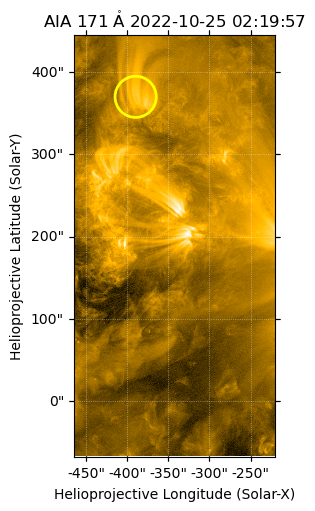

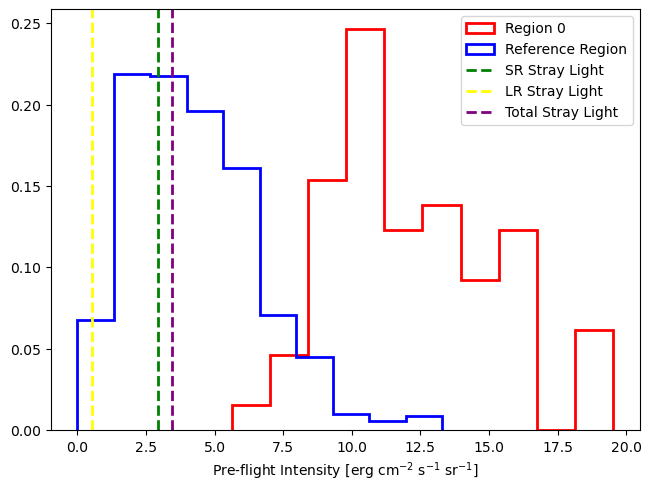

In [78]:
eis_FeIX_197_upflow_regions_int_mean_radcal, \
eis_FeIX_197_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_09_197_862.1c-0', cs_regions,
                                                                                 reference_region_params=coronal_hole_ref_region_params,
                                                                                 short_range_stray_light=True,
                                                                                 long_range_stray_light=True,
                                                                                 long_range_stray_light_aia_ref=aia_171_map,
                                                                                 long_range_stray_light_ref_center=[-390,370]*u.arcsec,
                                                                                 long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_10_184_536.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


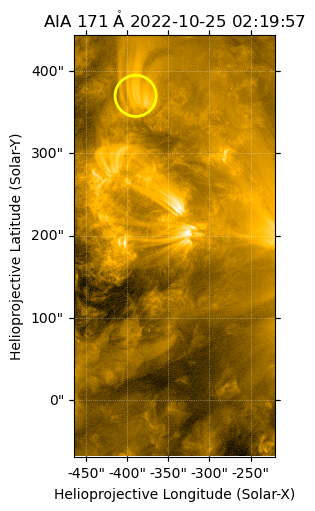

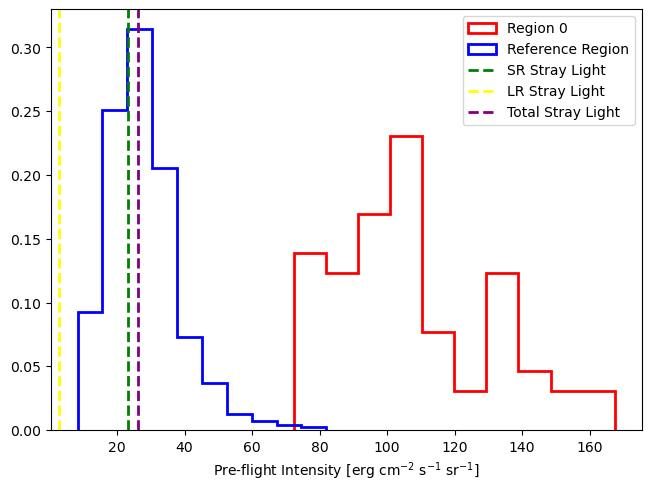

In [79]:
eis_FeX_184_upflow_regions_int_mean_radcal, \
eis_FeX_184_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_10_184_536.1c-0', cs_regions,
                                                                                reference_region_params=coronal_hole_ref_region_params,
                                                                                short_range_stray_light=True,
                                                                                long_range_stray_light=True,
                                                                                long_range_stray_light_aia_ref=aia_171_map,
                                                                                long_range_stray_light_ref_center=[-390,370]*u.arcsec,
                                                                                long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_11_188_216.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


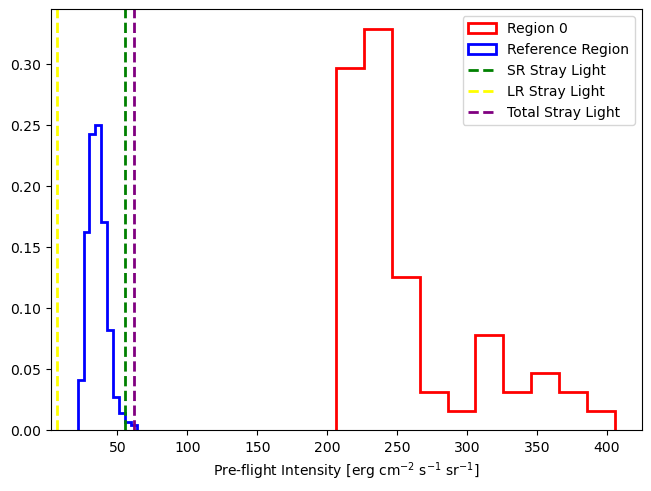

In [80]:
eis_FeXI_188_216_upflow_regions_int_mean_radcal, \
eis_FeXI_188_216_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_11_188_216.2c-0', cs_regions,
                                                                                     reference_region_params=coronal_hole_ref_region_params,
                                                                                     short_range_stray_light=True,
                                                                                     long_range_stray_light=True,
                                                                                     long_range_stray_light_aia_ref=aia_193_map,
                                                                                     long_range_stray_light_ref_center=[-370,100]*u.arcsec,
                                                                                     long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_11_188_299.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


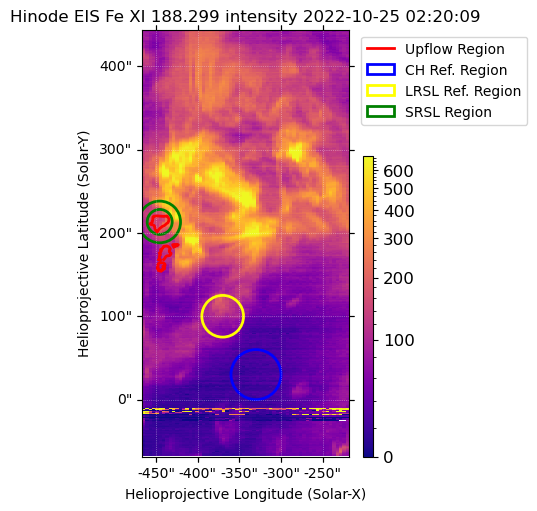

In [81]:
eis_FeXI_188_299_upflow_regions_int_mean_radcal, \
eis_FeXI_188_299_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_11_188_299.2c-1', cs_regions,
                                                                                     component=1, reference_region_params=coronal_hole_ref_region_params,
                                                                                     short_range_stray_light=True,
                                                                                     long_range_stray_light=True,
                                                                                     long_range_stray_light_aia_ref=aia_193_map,
                                                                                     long_range_stray_light_ref_center=[-370,100]*u.arcsec,
                                                                                     long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_192_394.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


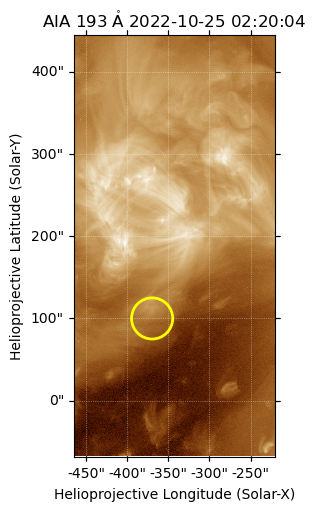

In [82]:
eis_FeXII_192_upflow_regions_int_mean_radcal, \
eis_FeXII_192_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_192_394.1c-0', cs_regions,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_193_map,
                                                                                  long_range_stray_light_ref_center=[-370,100]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


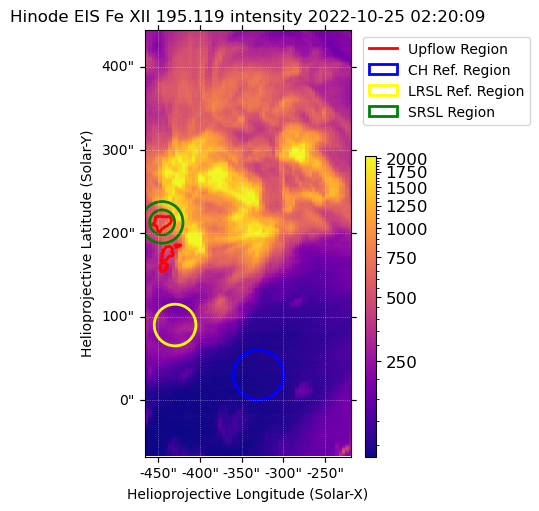

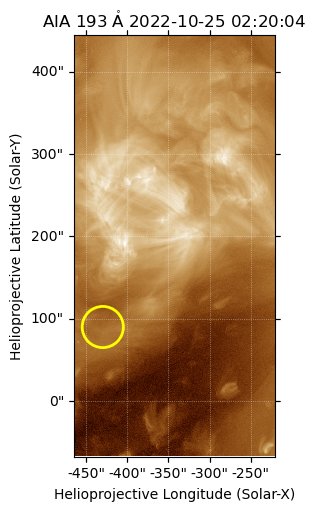

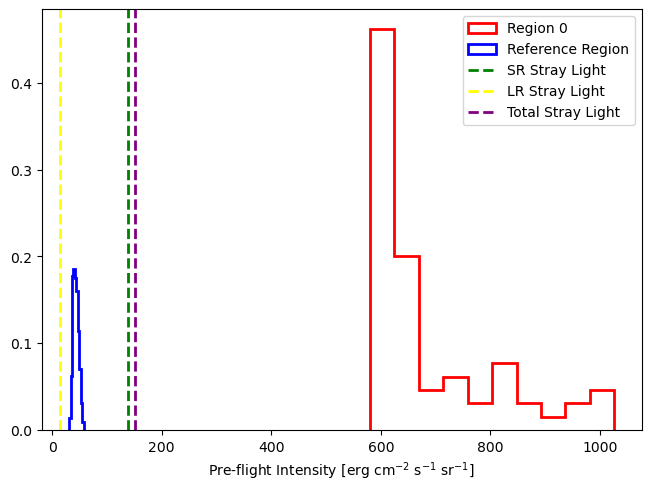

In [83]:
eis_FeXII_195_upflow_regions_int_mean_radcal, \
eis_FeXII_195_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_195_119.1c-0', cs_regions,
                                                                                    reference_region_params=coronal_hole_ref_region_params,
                                                                                    short_range_stray_light=True,
                                                                                    long_range_stray_light=True,
                                                                                    long_range_stray_light_aia_ref=aia_193_map,
                                                                                    long_range_stray_light_ref_center=[-430,90]*u.arcsec,
                                                                                    long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_13_202_044.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


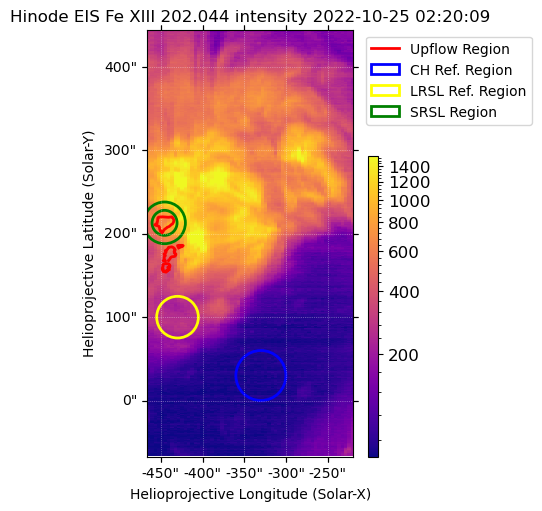

In [84]:
eis_FeXIII_202_upflow_regions_int_mean_radcal, \
eis_FeXIII_202_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_13_202_044.1c-0', cs_regions,
                                                                                   reference_region_params=coronal_hole_ref_region_params,
                                                                                   short_range_stray_light=True,
                                                                                   long_range_stray_light=True,
                                                                                   long_range_stray_light_aia_ref=aia_193_map,
                                                                                   long_range_stray_light_ref_center=[-430,100]*u.arcsec,
                                                                                   long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_203_720.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


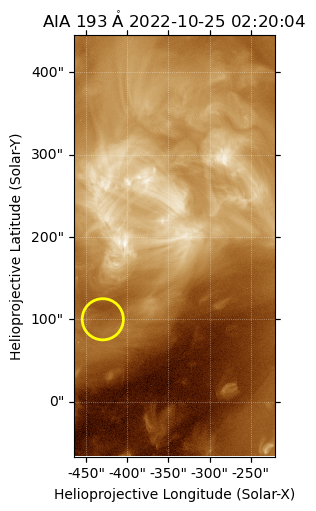

In [85]:
eis_FeXII_203_720_upflow_regions_int_mean_radcal, \
eis_FeXII_203_720_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_203_720.2c-0', cs_regions,
                                                                                      reference_region_params=coronal_hole_ref_region_params,
                                                                                      short_range_stray_light=True,
                                                                                      long_range_stray_light=True,
                                                                                      long_range_stray_light_aia_ref=aia_193_map,
                                                                                      long_range_stray_light_ref_center=[-430,100]*u.arcsec,
                                                                                      long_range_stray_light_ref_radius=50*u.arcsec)

In [86]:
eis_FeXIII_203_826_upflow_regions_int_mean_radcal, \
eis_FeXIII_203_826_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_13_203_826.2c-1', cs_regions,
                                                                                       component=1, reference_region_params=coronal_hole_ref_region_params,
                                                                                       short_range_stray_light=True,
                                                                                       long_range_stray_light=True,
                                                                                       long_range_stray_light_aia_ref=aia_193_map,
                                                                                        long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                        long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_13_203_826.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_14_264_787.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


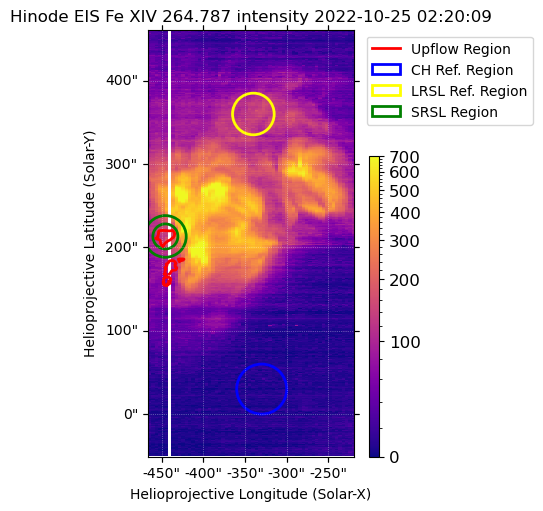

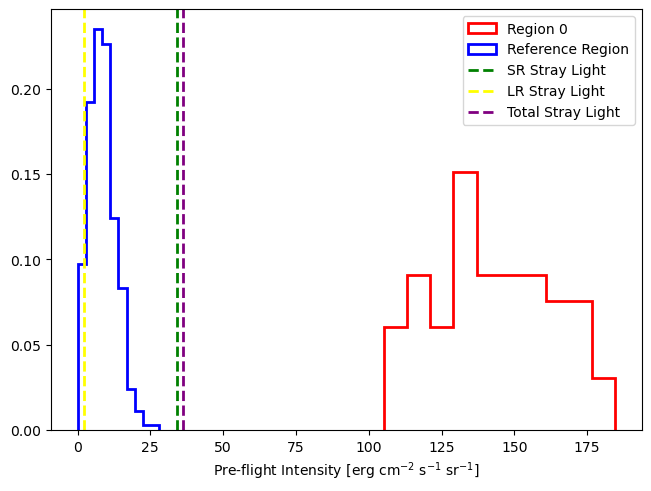

In [88]:
eis_FeXIV_264_upflow_regions_int_mean_radcal, \
eis_FeXIV_264_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_14_264_787.1c-0', cs_regions,
                                                                                  int_hist=0,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_211_map,
                                                                                  long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec)


Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_14_270_519.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


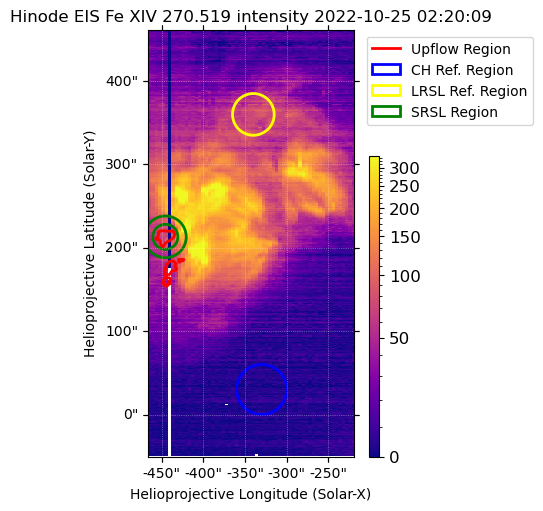

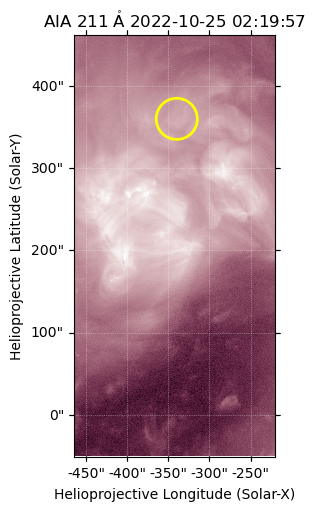

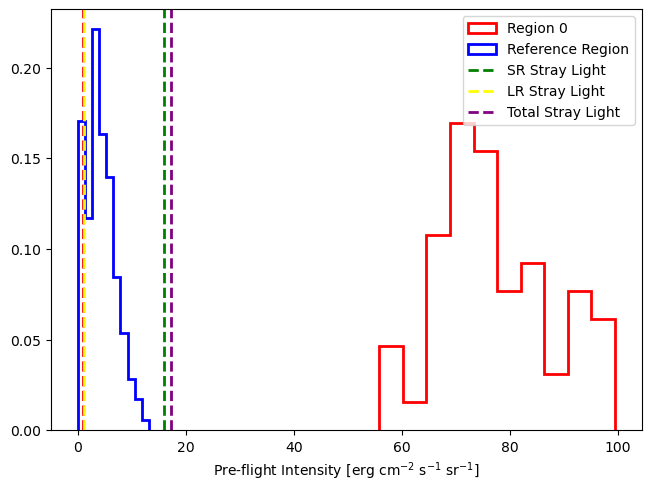

In [93]:
eis_FeXIV_270_upflow_regions_int_mean_radcal, \
eis_FeXIV_270_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_14_270_519.2c-1', cs_regions,
                                                                                  component=1,int_hist=0, min=1,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_211_map,
                                                                                  long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec,
                                                                                  eis_chi2_mask_threshold=10)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_15_284_160.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


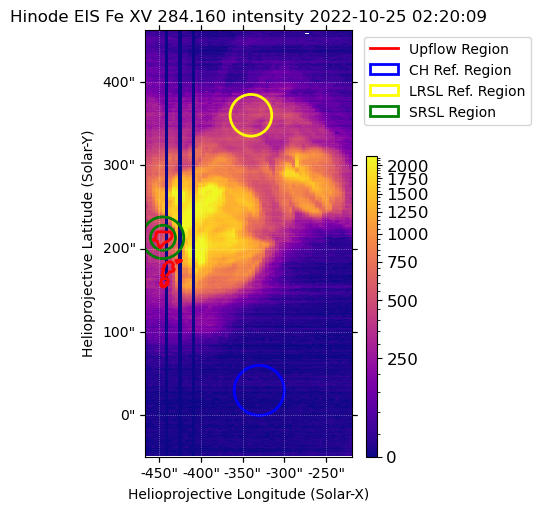

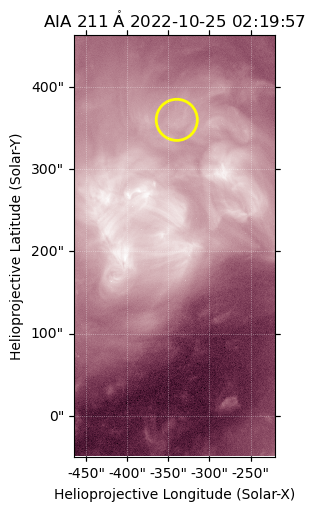

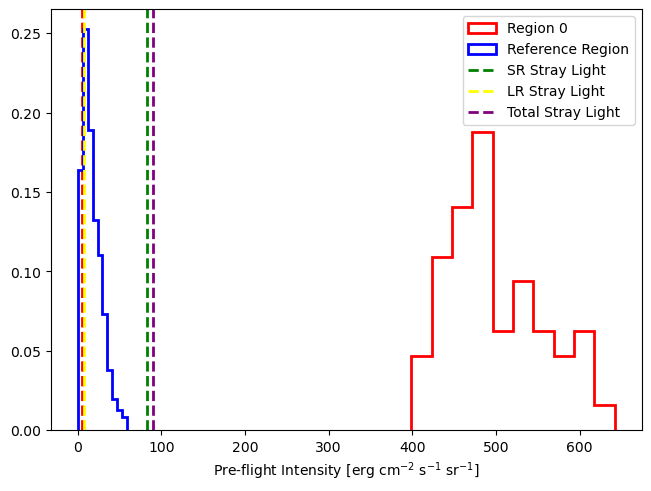

In [96]:
eis_FeXV_284_upflow_regions_int_mean_radcal, \
eis_FeXV_284_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_15_284_160.1c-0', cs_regions,
                                                                                 int_hist=0, min = 5,
                                                                                 reference_region_params=coronal_hole_ref_region_params,
                                                                                 short_range_stray_light=True,
                                                                                 long_range_stray_light=True,
                                                                                 long_range_stray_light_aia_ref=aia_211_map,
                                                                                 long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                 long_range_stray_light_ref_radius=50*u.arcsec,
                                                                                 eis_chi2_mask_threshold=10)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_16_262_984.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


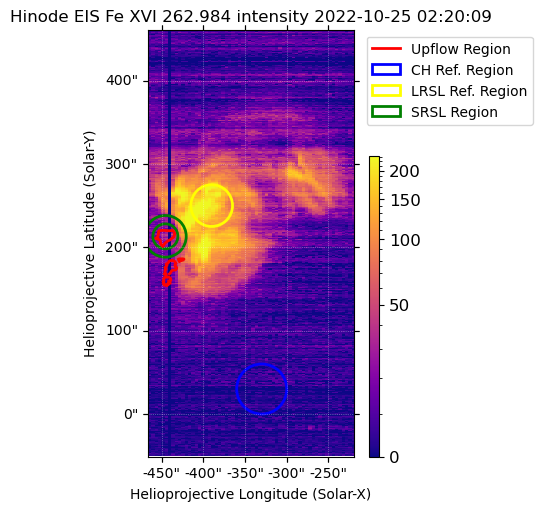

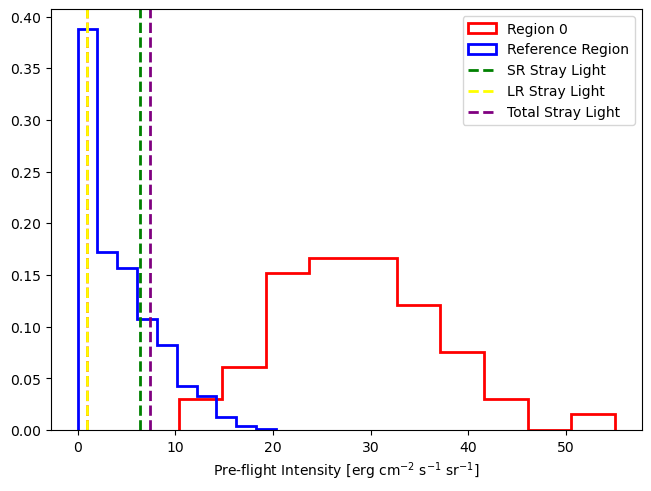

In [99]:
eis_FeXVI_262_upflow_regions_int_mean_radcal, \
eis_FeXVI_262_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_16_262_984.1c-0', cs_regions,
                                                                                    int_hist=0, min=1,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_335_map,
                                                                                  long_range_stray_light_ref_center=[-390,250]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec)

In [100]:
eis_OIV_279_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'o__04_279_933.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.o__04_279_933.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.o__06_184_117.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


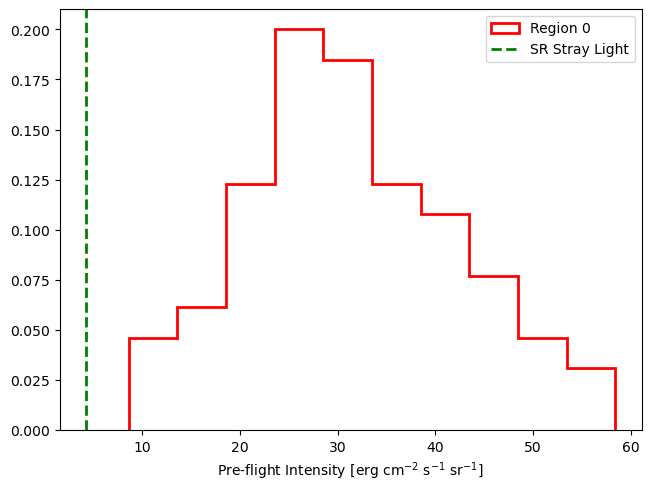

In [101]:
eis_OVI_184_upflow_regions_int_mean_radcal, \
eis_OVI_184_upflow_regions_stray_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'o__06_184_117.1c-0', cs_regions,
                                                                                 short_range_stray_light=True,)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.mg_06_270_394.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


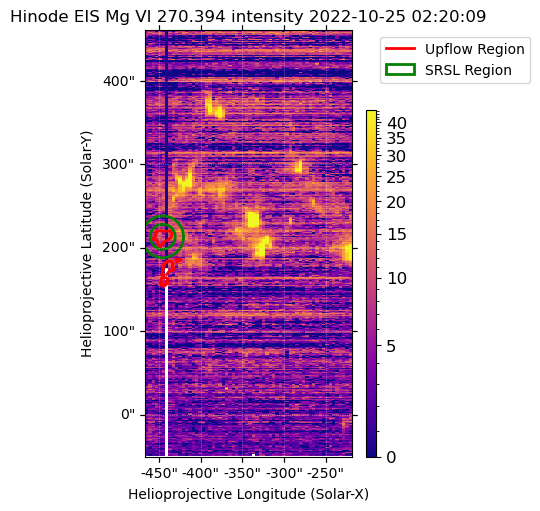

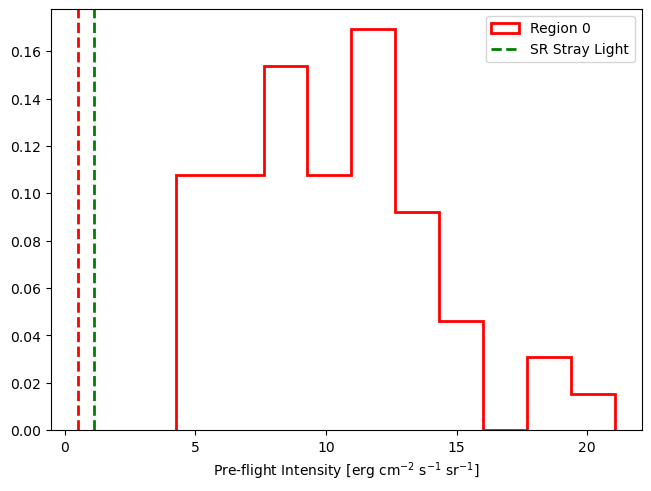

In [105]:
eis_MgVI_270_upflow_regions_int_mean_radcal, \
eis_MgVI_270_upflow_regions_stray_light_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_06_270_394.2c-0', cs_regions,
                                                                                 min=0.5,short_range_stray_light=True,)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.si_07_275_368.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


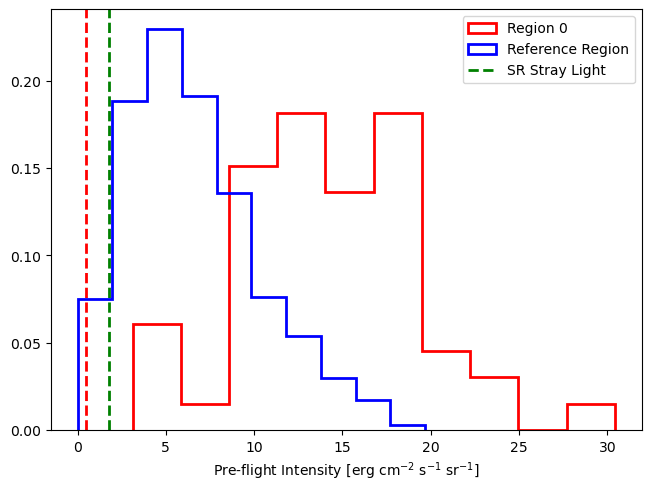

In [107]:
eis_SiVII_275_upflow_regions_int_mean_radcal, \
eis_SiVII_275_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_07_275_368.1c-0', cs_regions,min=0.5,
                                                                                         reference_region_params=coronal_hole_ref_region_params,
                                                                                         short_range_stray_light=True,)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.mg_07_276_153.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


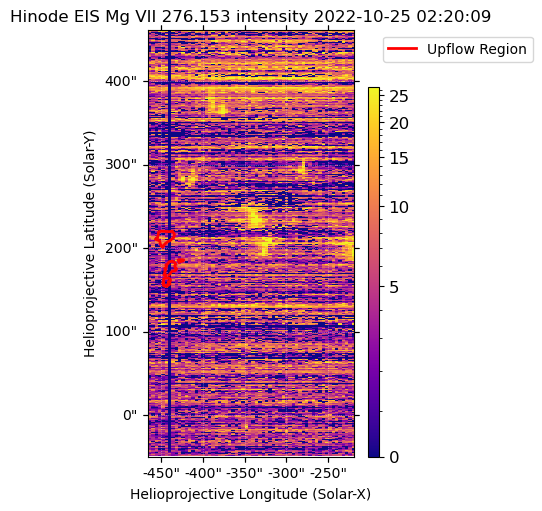

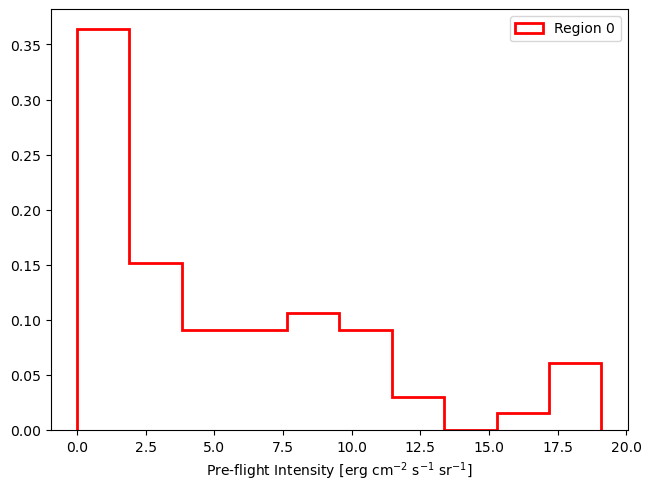

In [109]:
eis_MgVII_276_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_07_276_153.1c-0', cs_regions,
                                                                                  int_hist=0)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.mg_07_280_737.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


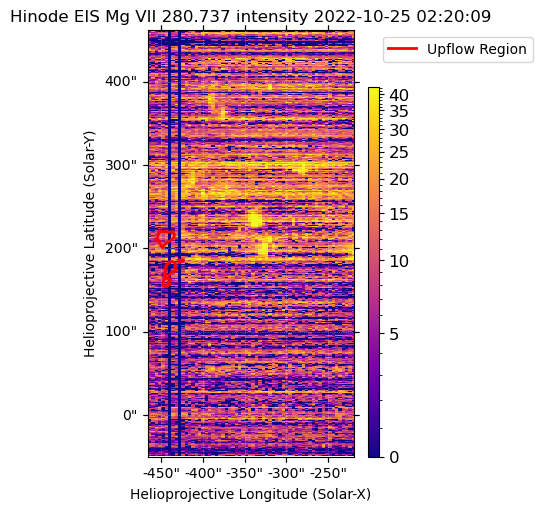

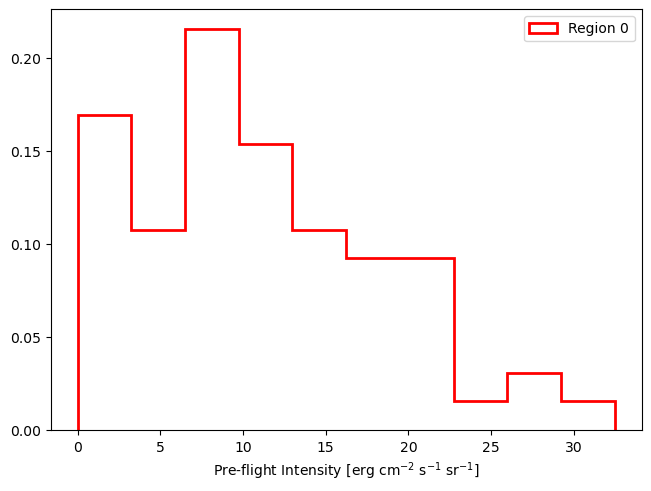

In [110]:
eis_MgVII_280_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_07_280_737.1c-0', cs_regions,
                                                                                  int_hist=0)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.si_10_258_375.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


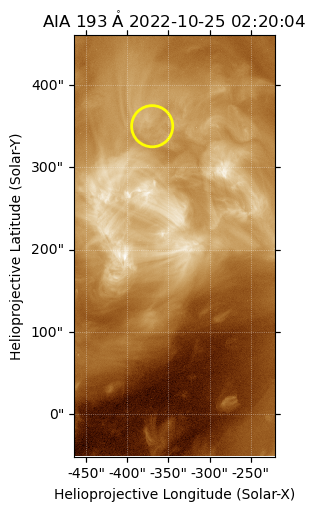

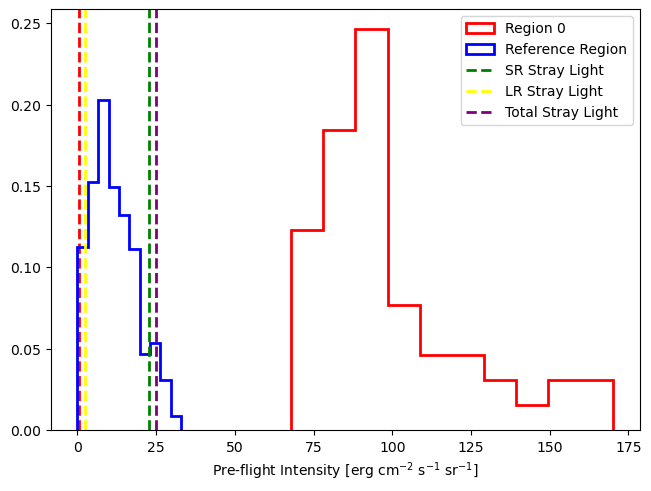

In [112]:
eis_SiX_258_upflow_regions_int_mean_radcal, \
eis_SiX_258_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_10_258_375.1c-0', cs_regions,
                                                                                min=0.5,
                                                                                reference_region_params=coronal_hole_ref_region_params,
                                                                                short_range_stray_light=True,
                                                                                long_range_stray_light=True,
                                                                                long_range_stray_light_aia_ref=aia_193_map,
                                                                                long_range_stray_light_ref_center=[-370,350]*u.arcsec,
                                                                                long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.si_10_261_058.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


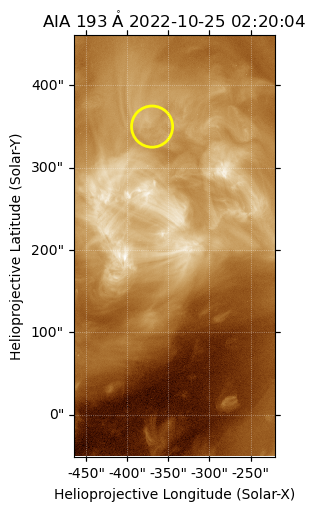

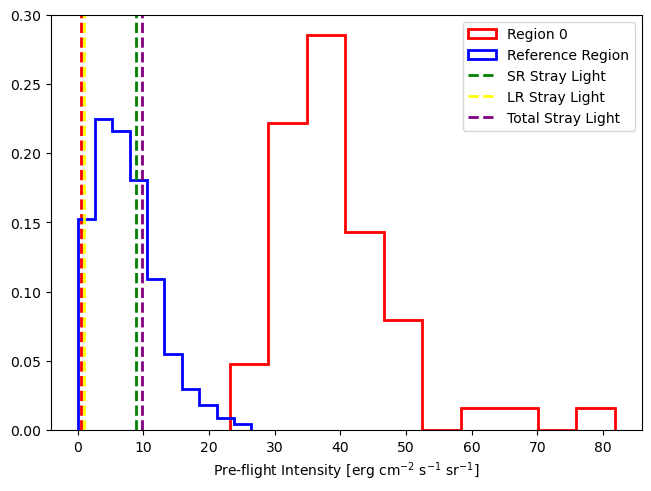

In [114]:
eis_SiX_261_upflow_regions_int_mean_radcal, \
eis_SiX_261_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_10_261_058.1c-0', cs_regions,
                                                                                       min=0.5,
                                                                                reference_region_params=coronal_hole_ref_region_params,
                                                                                short_range_stray_light=True,
                                                                                long_range_stray_light=True,
                                                                                long_range_stray_light_aia_ref=aia_193_map,
                                                                                long_range_stray_light_ref_center=[-370,350]*u.arcsec,
                                                                                long_range_stray_light_ref_radius=50*u.arcsec)

In [115]:
def dens_diag(ratio, chianti_file):
    chianti_pf = pd.read_csv(chianti_file,skiprows=6,sep=r'\s+',names=['dens','ratio'])
    chianti_dens, chianti_ratio = chianti_pf['dens'], chianti_pf['ratio']
    dens_interp_func = scipy.interpolate.interp1d(chianti_ratio, chianti_dens, kind='cubic', fill_value='extrapolate')

    return dens_interp_func(ratio)

In [116]:
SiX_dens_upflow_regions = dens_diag(eis_SiX_258_upflow_regions_int_mean_radcal/eis_SiX_261_upflow_regions_int_mean_radcal,
                                    '../../sav/CHIANTI/SiX_285_261_dens.txt')
SiX_dens_upflow_regions

array([4.14130560e+08, 5.64665767e+08, 1.94550112e+08, 4.34649151e+08])

In [117]:
SiX_dens_upflow_regions_sl_removed = dens_diag((eis_SiX_258_upflow_regions_int_mean_radcal - np.nansum(eis_SiX_258_upflow_regions_stray_light_int_radcal,axis=1))/
                                               (eis_SiX_261_upflow_regions_int_mean_radcal - np.nansum(eis_SiX_261_upflow_regions_stray_light_int_radcal,axis=1)),
                                               '../../sav/CHIANTI/SiX_285_261_dens.txt')
SiX_dens_upflow_regions_sl_removed

array([4.03178083e+08, 6.78103917e+08, 1.59097397e+08, 3.63501375e+08])

In [118]:
MgVII_dens_upflow_regions = dens_diag(eis_MgVII_276_upflow_regions_int_mean_radcal/eis_MgVII_280_upflow_regions_int_mean_radcal,
                                        '../../sav/CHIANTI/MgVII_276_280.txt')
MgVII_dens_upflow_regions

array([2.65355820e+09, 1.29427712e+09, 2.70754462e+09, 4.54505832e+08])

In [119]:
FeXIII_dens_upflow_regions = dens_diag(eis_FeXIII_202_upflow_regions_int_mean_radcal/eis_FeXIII_203_826_upflow_regions_int_mean_radcal,
                                        '../../sav/CHIANTI/FeXIII_202_203_dens.txt')
FeXIII_dens_upflow_regions

array([3.91019812e+08, 3.84972736e+08, 3.18352737e+08, 3.23750612e+08])

In [121]:
FeXIII_dens_upflow_regions_sl_removed = dens_diag((eis_FeXIII_202_upflow_regions_int_mean_radcal - np.nansum(eis_FeXIII_202_upflow_regions_stray_light_int_radcal,axis=1))/
                                                    (eis_FeXIII_203_826_upflow_regions_int_mean_radcal - np.nansum(eis_FeXIII_203_826_upflow_regions_stray_light_int_radcal,axis=1)),
                                                    '../../sav/CHIANTI/FeXIII_202_203_dens.txt')
FeXIII_dens_upflow_regions_sl_removed

array([3.77977709e+08, 3.33994745e+08, 2.12442443e+08, 1.66453226e+24])

In [129]:
upflow_region_0_dem_wvl = np.array([185.213, 186.598, 188.493, 197.854, 184.537,
                                    188.216, 188.299, 192.394, 195.119, 203.728,
                                    202.044, 203.810, 264.788, 270.520, 284.163, 
                                    262.976])
upflow_region_0_dem_int = np.vstack([eis_FeVIII_185_upflow_regions_int_mean_radcal,
                                     eis_FeVIII_186_upflow_regions_int_mean_radcal,
                                     eis_FeIX_188_upflow_regions_int_mean_radcal,
                                     eis_FeIX_197_upflow_regions_int_mean_radcal,
                                     eis_FeX_184_upflow_regions_int_mean_radcal,
                                     eis_FeXI_188_216_upflow_regions_int_mean_radcal,
                                     eis_FeXI_188_299_upflow_regions_int_mean_radcal,
                                     eis_FeXII_192_upflow_regions_int_mean_radcal,
                                     eis_FeXII_195_upflow_regions_int_mean_radcal,
                                     eis_FeXII_203_720_upflow_regions_int_mean_radcal,
                                     eis_FeXIII_202_upflow_regions_int_mean_radcal,
                                     eis_FeXIII_203_826_upflow_regions_int_mean_radcal,
                                     eis_FeXIV_264_upflow_regions_int_mean_radcal,
                                     eis_FeXIV_270_upflow_regions_int_mean_radcal,
                                     eis_FeXV_284_upflow_regions_int_mean_radcal,
                                     eis_FeXVI_262_upflow_regions_int_mean_radcal])[:,0]

upflow_region_0_dem_int_err = upflow_region_0_dem_int*0.2

upflow_region_0_den_wvl_hwhm = np.ones_like(upflow_region_0_dem_wvl)*0.001
upflow_region_0_den_wvl_hwhm[11] = 0.016

upflow_region_0_dem_des = ['Fe VIII 185', 'Fe VIII 186', 'Fe IX 188', 'Fe IX 197', 'Fe X 184',
                           'Fe XI 188.216', 'Fe XI 188.299', 'Fe XII 192', 'Fe XII 195', 'Fe XII 203.720',
                           'Fe XIII 202', 'Fe XIII 203.826/.795', 'Fe XIV 264', 'Fe XIV 270', 'Fe XV 284',
                           'Fe XVI 262']


In [130]:
upflow_region_0_chianti_input_pf = pd.DataFrame({'wvl':upflow_region_0_dem_wvl,
                                                    'int':upflow_region_0_dem_int,
                                                    'int_err':upflow_region_0_dem_int_err,
                                                    'hwhm':upflow_region_0_den_wvl_hwhm,
                                                    'des':upflow_region_0_dem_des})
upflow_region_0_chianti_input_pf.to_csv('../../sav/CHIANTI/dem_input/east_upflow_region_0_chianti_input_pf.txt',index=False,
                                        header=False, sep=' ',)
upflow_region_0_chianti_input_pf

wvl          int     int_err   hwhm                   des
0   185.213    71.286973   14.257395  0.001           Fe VIII 185
1   186.598    40.693600    8.138720  0.001           Fe VIII 186
2   188.493    19.992204    3.998441  0.001             Fe IX 188
3   197.854    12.833708    2.566742  0.001             Fe IX 197
4   184.537   148.745973   29.749195  0.001              Fe X 184
5   188.216   268.763781   53.752756  0.001         Fe XI 188.216
6   188.299   176.225930   35.245186  0.001         Fe XI 188.299
7   192.394   177.257966   35.451593  0.001            Fe XII 192
8   195.119   665.390007  133.078001  0.001            Fe XII 195
9   203.728    40.417066    8.083413  0.001        Fe XII 203.720
10  202.044   469.804688   93.960938  0.001           Fe XIII 202
11  203.810   175.383884   35.076777  0.016  Fe XIII 203.826/.795
12  264.788   539.958264  107.991653  0.001            Fe XIV 264
13  270.520   366.653223   73.330645  0.001            Fe XIV 270
14  284.163  2240.127137  448.025427  0.001             Fe XV 284
15  262.976    93.515303   18.703061  0.001            Fe XVI 262

In [131]:
upflow_region_0_dem_int_sr_removed = \
    np.array([eis_FeVIII_185_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeVIII_185_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeVIII_186_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeVIII_186_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeIX_188_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeIX_188_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeIX_197_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeIX_197_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeX_184_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeX_184_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXI_188_216_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXI_188_216_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXI_188_299_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXI_188_299_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXII_192_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXII_192_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXII_195_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXII_195_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXII_203_720_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXII_203_720_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIII_202_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIII_202_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIII_203_826_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIII_203_826_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIV_264_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIV_264_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIV_270_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIV_270_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXV_284_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXV_284_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXVI_262_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXVI_262_upflow_regions_stray_light_int_radcal[0,:])])

upflow_region_0_dem_int_sr_removed_err = upflow_region_0_dem_int_sr_removed*0.23


In [132]:
upflow_region_0_chianti_input_pf_sr_removed = pd.DataFrame({'wvl':upflow_region_0_dem_wvl,
                                                    'int':upflow_region_0_dem_int_sr_removed,
                                                    'int_err':upflow_region_0_dem_int_sr_removed_err,
                                                    'hwhm':upflow_region_0_den_wvl_hwhm,
                                                    'des':upflow_region_0_dem_des})
upflow_region_0_chianti_input_pf_sr_removed.to_csv('../../sav/CHIANTI/dem_input/east_upflow_region_0_chianti_input_pf_sr_removed.txt',index=False,
                                        header=False, sep=' ',)
upflow_region_0_chianti_input_pf_sr_removed

wvl          int     int_err   hwhm                   des
0   185.213    54.981157   12.645666  0.001           Fe VIII 185
1   186.598    32.956685    7.580037  0.001           Fe VIII 186
2   188.493    14.394552    3.310747  0.001             Fe IX 188
3   197.854     9.204974    2.117144  0.001             Fe IX 197
4   184.537   112.631043   25.905140  0.001              Fe X 184
5   188.216   203.555535   46.817773  0.001         Fe XI 188.216
6   188.299   132.265586   30.421085  0.001         Fe XI 188.299
7   192.394   146.650551   33.729627  0.001            Fe XII 192
8   195.119   518.433359  119.239672  0.001            Fe XII 195
9   203.728    30.149687    6.934428  0.001        Fe XII 203.720
10  202.044   376.272780   86.542739  0.001           Fe XIII 202
11  203.810   126.146832   29.013771  0.016  Fe XIII 203.826/.795
12  264.788   402.118439   92.487241  0.001            Fe XIV 264
13  270.520   284.951602   65.538869  0.001            Fe XIV 270
14  284.163  1837.655651  422.660800  0.001             Fe XV 284
15  262.976    69.109156   15.895106  0.001            Fe XVI 262

In [133]:
eis_FeXV_284_fitres = eispac.read_fit(eis_file_prefix + 'fe_15_284_160.1c-0.fit.h5')
eis_FeXV_284_velmap = eis_FeXV_284_fitres.get_map(component=0, measurement='velocity')

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_15_284_160.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


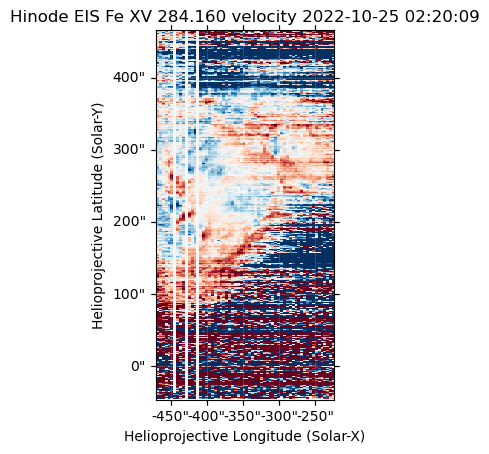

In [134]:
eis_FeXV_284_velmap.plot(norm=None,vmin=-10,vmax=10)